In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import math
# from google.colab import files
from random import randrange
from scipy.linalg import block_diag
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import time
from scipy.stats import beta
# from google.colab import files
from datetime import datetime

nowstr = datetime.now().strftime("%m-%d-%Y_%H-%M-%S_")
RK4_time=0
unfold_time=0
model_time=0
grad_time=0
traject_time=0
seed = 1  # seed of random numbers
torch.manual_seed(int(seed)) # initialization of seed of random numbers for pytorch
np.random.seed(seed)
# ave=0
# sum=0
# cnt=0

In [2]:


class L63(nn.Module):
    def __init__(self, T, umin, umax):
        # もろもろのパラメータを定義
        super(L63, self).__init__()

        # 予測区間の長さ？
        self.predictionHorizon = T

        # モデル予測制御をかける時間の長さ
        self.MPCfinalTime = 1000
        #

        # self.MPCfinalTime = 10

        # number of noise paths used for each iteration
        # self.m = 10
        self.m=3
        self.batchSize = 1
        self.lr =10

        self.xave=1.00
        self.xcnt=1.00
        self.xsum=1.00
        self.relu = nn.ReLU()

        self.before=torch.zeros(3,2000)
        self.step=0
        self.state=torch.zeros(3,self.predictionHorizon)
        self.is_first=1

        # 制御入力の大きさの上限と下限
        self.umax = umax
        self.umin = umin

        # システムの初期値
        # self.x0 = torch.tensor(np.array([8.20, 10.08, 23.86]))  # good
        # self.x0 = torch.tensor(np.array([16.1, -5.2, 2.4]))

        # for beta distributions...
        # 一様分布
        self.alpha = 1
        self.beta = 1

        # noise の大きさ
        self.minw = -.1
        self.maxw = .1
        # 第二要素にかける数
        self.w2factor = 20

        # いろいろなパラメータ．システムの
        # self.v = nn.Parameter(torch.zeros(1, self.predictionHorizon-1, dtype=torch.double))
        self.v = nn.Parameter(torch.normal(0, 1, size=(3, self.predictionHorizon-1)))
        self.p=torch.tensor(10)
        self.r=torch.tensor(32)
        self.b=torch.tensor(8/3)
        self.Ts = torch.tensor(0.01)

       

    def RK4(self,xold):
        global RK4_time
        start = time.time()
        xnew=torch.zeros(3)
        k1=torch.zeros(3)
        k2=torch.zeros(3)
        k3=torch.zeros(3)
        k4=torch.zeros(3)

        k1=self.florenzcontrol(xold)
        k2=self.florenzcontrol(xold+k1*self.Ts/2.)
        k3=self.florenzcontrol(xold+k2*self.Ts/2.)
        k4=self.florenzcontrol(xold+k3*self.Ts)
        
        xnew[0]=xold[0]+self.Ts/6.0*(k1[0]+2.0*k2[0]+2.0*k3[0]+k4[0])
        xnew[1]=xold[1]+self.Ts/6.0*(k1[1]+2.0*k2[1]+2.0*k3[1]+k4[1])
        xnew[2]=xold[2]+self.Ts/6.0*(k1[2]+2.0*k2[2]+2.0*k3[2]+k4[2])
        RK4_time+=time.time() - start
        # print(RK4_time)
        return xnew

    # self.relu = nn.ReLU()
    # システムを１ステップ進める関数
    def forward(self, u):
        self.x0 = self.f(self.x0.detach(),u)
        self.step=self.step+1

    # 飽和関数
    def sat(self, v):
        return torch.sigmoid(v/20)*(self.umax-self.umin)+self.umin
        # return v
    
    def florenz(self,x):
        dxyz=torch.zeros_like(x)
        dxyz[0] = -self.p * x[0] + self.p * x[1]
        dxyz[1] = (self.r - x[2]) * x[0] - x[1] 
        dxyz[2] = x[0] * x[1] - self.b * x[2]
        return dxyz

   
    def florenzcontrol(self, x):
        dxyz=torch.zeros_like(x)
        dxyz[0] = -self.p * x[0].clone() + self.p * x[1].clone()
        dxyz[1] = (self.r - x[2].clone()) * x[0].clone() - x[1].clone()
        dxyz[2] = x[0].clone() * x[1].clone() - self.b * x[2].clone()

        return dxyz
    
     # システムの関数 x(k+1) = f(x(k), u(k), w(k))
    def f(self, x, u):
        x1,y1,z1=self.florenzcontrol(x)
        # dx=self.Ts*torch.cat([x1.reshape(1),y1.reshape(1),z1.reshape(1)],0).view(-1,1,1)
        x_next=torch.zeros(3)
        x_next=self.RK4(x)

        
        x_next[0]=x_next[0]+u[0]
        x_next[1]=x_next[1]+u[1]
        x_next[2]=x_next[2]+u[2]
        
        return x_next


    # quadratic costs
    def stageCost(self, x, u):
        # if x[0]<0:
        #      cost=x[0]
        # else :
        #     cost=x[0]*0.0000001
            
        cost=self.relu(-x[0])
        
        return cost
    
    def finalStageCost(self, x):
        # if x[0]<0:
        #     # cost=x[0]
        #      cost=x[0]
        # else :
        #     cost=x[0]*0.0000001
        cost=self.relu(-x[0])   
        return cost
        

    # ノイズ系列 w が入ってきたときの状態の軌道
    def trajectoryforMPC(self,u, w):
        global traject_time
        start = time.time()
        x = torch.zeros(3, self.predictionHorizon)
        # t=self.predictionHorizon-1
        x[:, 0] = self.x0.float()+np.random.normal(loc=0,scale=math.sqrt(2),size=3)
            # 最初の時刻の入力は u なので
        x[:, 1] = self.f(x[:, 0], u)
        for i in range(1, self.predictionHorizon-1):
             x[:, i+1] = self.f(x[:, i], self.sat(self.v[:, [i]]))
        traject_time+=time.time() - start
        return x

    # なぞ
    def sampleJforMPC(self, u, w, T):
        x = self.trajectoryforMPC(u, w)
        cost = torch.tensor(0)
        for i in range(T-1):
            cost = cost + self.stageCost(x[:, i], self.sat(self.v[:, [i]]))
        return cost + self.finalStageCost(x[:, T-1])

    # なぞ
    def sampleBatchJforMPC(self, u, T):
        cost = torch.zeros(( self.batchSize))
        for i in range(self.batchSize):
            cost[i] = self.sampleJforMPC(u, self.w_for_training(), T)
        return cost

    # ノイズを生成する関数
    def w_for_training(self):
        # return torch.tensor(beta.rvs(self.alpha, self.beta, size=(3, self.predictionHorizon), loc=self.minw, scale=self.maxw-self.minw))
        return torch.normal(mean=0,std=1.4,size=(3, self.predictionHorizon))
    # 同上
    def w_for_evaluation(self, T):
        # return torch.tensor(beta.rvs(self.alpha, self.beta, size=(3, T),loc=self.minw, scale=self.maxw-self.minw))
        return torch.normal(mean=0,std=1.4,size=(3, T))

    # なぞ
    def unfoldTrainForMPC(self, currentInput):
        global unfold_time
        start = time.time()
        opt = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        loss_func = nn.L1Loss()
        for T in range(2, self.predictionHorizon+1):
            # print(self.sampleJ(wSample, self.predictionHorizon).detach().numpy())
            # target = torch.ones([1,self.batchSize])*(30)
            target = torch.zeros([1,self.batchSize])
            for i in range(self.m):
                global grad_time
                
                opt.zero_grad()
                # self.sampleBatchJforMPC(currentInput, T).backward(retain_graph=True)
                start2 = time.time()
                loss_func(self.sampleBatchJforMPC(currentInput, T),target).backward(retain_graph=True)
                
                opt.step()
                grad_time+=time.time() - start2
                
        # T=self.predictionHorizon
            # print(self.sampleJ(wSample, self.predictionHorizon).detach().numpy())
        # target = torch.zeros([1,self.batchSize])
        # target = torch.ones([1,self.batchSize])*50
        # for i in range(self.m):
        #         opt.zero_grad()
        #         # self.sampleBatchJforMPC(currentInput, T).backward(retain_graph=True)
        #         loss_func(self.sampleBatchJforMPC(currentInput, T),target).backward(retain_graph=True)
        #         opt.step()
       
        # elapsed_time = time.time() - start
        self.u = self.sat(self.v)
        unfold_time+=time.time() - start
        # print("unfold_time",unfold_time)





In [3]:
# 実際にモデル予測制御をする関数


def MPC(x0, umin, umax):
    predictionHorizon = 20
    # Model = L63(predictionHorizon, umin, umax)
    # myModel = torch.jit.trace(Model)
    
    myModel = L63(predictionHorizon, umin, umax)
    myModel.x0 = torch.tensor(x0)



    x = np.zeros((3, myModel.MPCfinalTime+1))
    u = np.zeros((3, myModel.MPCfinalTime+1))
    w = myModel.w_for_evaluation(myModel.MPCfinalTime+1)
    elapsed_time = np.empty(0)
    for i in range(myModel.MPCfinalTime):
        # print(i)
        # x[:, [i]] = myModel.x0.detach().numpy()
        x[:, i] = myModel.x0.detach().numpy()
        # etime = myModel.unfoldTrainForMPC(u[:, i])
        myModel.unfoldTrainForMPC(u[:, [i]])
        u[:, [i+1]] = myModel.sat(myModel.v[:, [1]]).detach().numpy()

        # u[0, [i+1]] = myModel.sat(myModel.v[0, [1]]).detach().numpy()

        myModel.forward(u[:, i])
        newx0 = myModel.x0.detach()
        global model_time
        start = time.time()
        myModel = L63(predictionHorizon, umin, umax)
        myModel.x0 = newx0
        model_time+=time.time() - start
    x[:, myModel.MPCfinalTime] = myModel.x0.detach().numpy()
    return x, u, w
  



In [4]:
umin=-0.28867513459
umax=0.28867513459
x01=np.array([8.20747939, 10.0860429, 23.86324441])
#1 x01=np.array([-10.22113609 ,-18.58426094, 18.14793777])
#2 x01=np.array([12.02141953, 11.9007988,  35.07586288])
#3 x01=np.array([1.2138406,   2.21369243, 16.16892815])
# x01=np.array([14.99936199, 19.97302818, 33.87895584])
# x01=np.array([-6.58101654, -7.19674015, 26.89758301])
# x01=np.array([-4.35934687, -7.11497164, 17.98123169])
# x01=np.array([4.48994207, 9.03487206, 9.57548046])
# x01=np.array([-5.09989738,  2.10293293, 34.70569611])
 
x1,u1,w1=MPC(x01,umin,umax)
print("RK4_time",RK4_time)
print("unfold_time",unfold_time)
print("model_time",model_time)
print("grad_time",grad_time)
print("traject_time",traject_time)


/home/rk-nagai/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RK4_time 612.586422920227
unfold_time 2071.3349883556366
model_time 0.12119507789611816
grad_time 2069.428944826126
traject_time 876.58837890625


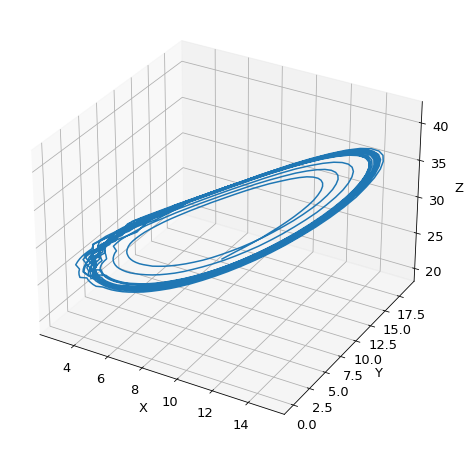

In [5]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(projection="3d")
# ax.scatter(*x1[0, :], c="red")
# ax.plot(*x1.transpose())
ax.plot(x1[0],x1[1],x1[2])
plt.xlabel('X')
plt.ylabel('Y')
ax.zlabel=ax.set_zlabel('Z')
plt.savefig('L63-2.png')
plt.show()

In [6]:
%matplotlib notebook
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111,projection="3d")
ims1=[]
# ims2=[]
for t in range(1000):
    # frame = plt.scatter(x, y, color='blue')
    im=ax.plot(x1[0,:t+1],x1[1,:t+1],x1[2,:t+1],'b-o')
    # title = ax.text(0.5, 1.1,1.0, f'TITLE {i}',transform=plt.gca().transAxes, ha='center', va='center', fontsize="large")
    ims1.extend([im])
ani=ArtistAnimation(fig,ims1,interval=100)
ani.save("test2.gif")
plt.show()

<IPython.core.display.Javascript object>